# Titanic Data Analysis and Logistic Regression
In this notebook I am goind to look at the *Titanic: Machine Learning from Disaster* dataset from Kaggle.   
Issues to be tackled will be missing values, feature engineering and logistic regression.

From https://www.kaggle.com/c/titanic/data we have this description of the features:
<table>
<tbody>
<tr><th><b>Variable</b></th><th><b>Definition</b></th><th><b>Key</b></th></tr>
<tr>
<td>survival</td>
<td>Survival</td>
<td>0 = No, 1 = Yes</td>
</tr>
<tr>
<td>pclass</td>
<td>Ticket class</td>
<td>1 = 1st, 2 = 2nd, 3 = 3rd</td>
</tr>
<tr>
<td>sex</td>
<td>Sex</td>
<td></td>
</tr>
<tr>
<td>Age</td>
<td>Age in years</td>
<td></td>
</tr>
<tr>
<td>sibsp</td>
<td># of siblings / spouses aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>parch</td>
<td># of parents / children aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>ticket</td>
<td>Ticket number</td>
<td></td>
</tr>
<tr>
<td>fare</td>
<td>Passenger fare</td>
<td></td>
</tr>
<tr>
<td>cabin</td>
<td>Cabin number</td>
<td></td>
</tr>
<tr>
<td>embarked</td>
<td>Port of Embarkation</td>
<td>C = Cherbourg, Q = Queenstown, S = Southampton</td>
</tr>
</tbody>
</table>

In [660]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [661]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Just from the info we can see that we only have:
* 714/891 *Age* values
* 204/891 *Cabin* values
* 889/891 *Embarked* values.

In [662]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


* We can drop the *PassenderId* since it conveys no information and we already have an index.
* We'll also drop *Ticket* because how should we interpret it?
* The Pclass feature, although numerical, is an ordinal feature so we'll need to create dummy variables.
* Sex is a string and needs to be converted to binary.
* We have so few values for the Cabin feature that we'll drop it for now and maybe come back to it later.
* We'll also drop the two passengers missing their embarked value.
* The embarked value is categorical, needs dummy variables.
* The missing age values could either be dropped or engineered based of other features.

In [663]:
df.drop('PassengerId', axis=1, inplace=True)

In [664]:
df.drop('Ticket', axis=1, inplace=True)

In [665]:
df.drop('Cabin', axis=1, inplace=True)

In [666]:
# Create dummy variables for categorical features with pandas get_dummies
sex = pd.get_dummies(df['Sex'], drop_first=True)
embarked = pd.get_dummies(df['Embarked'], drop_first=True)

In [667]:
# Drop Sex, Pclass and Embarked columns and concat the dummy variable dataframes created above
df.drop(['Sex','Embarked'], axis=1, inplace=True)

In [668]:
df = pd.concat([df,sex,embarked], axis=1, sort=False)

In [669]:
df.head()

,Survived,Pclass,Name,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,1,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,0,0,0
2,1,3,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,0,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,0,0,1
4,0,3,"Allen, Mr. William Henry",35.0,0,0,8.0500,1,0,1


We would now like to find a way to fill in the *Age* missing values. To do this we will look at the distribution of Age against the other features.  
Also we would like to decompose the Name to extract the title which is probably indicative of age.
Here I borrow a regular expression from the Titanic Data Science Solutions notebook on Kaggle to extract the title.

    ' ([A-Za-z]+)\.'
    
Matches the first word that ends in a full-stop.

    pandas.Series.str.extract
    
For each subject string in the Series, extract groups from the first match of regular expression pat.

In [670]:
# Create the new Title feature and drop the Name that we will no longer be using
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df.drop('Name', axis=1, inplace=True)

In [671]:
df['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Capt          1
Lady          1
Jonkheer      1
Don           1
Countess      1
Mme           1
Ms            1
Sir           1
Name: Title, dtype: int64

We are only be going to use these titles to engineer the missing Age values and ignore the possibility that nobles or other rare titles might have a different survival probability.

In [672]:
print('Mean age for Mr =', df[df['Title']=='Mr']['Age'].dropna().mean())
print('Mean age for Miss =', df[df['Title']=='Miss']['Age'].dropna().mean())
print('Mean age for Mrs =', df[df['Title']=='Mrs']['Age'].dropna().mean())
print('Mean age for Master =', df[df['Title']=='Master']['Age'].dropna().mean())
print('Mean age for Dr =', df[df['Title']=='Dr']['Age'].dropna().mean())
print('Mean age for Rev =', df[df['Title']=='Rev']['Age'].dropna().mean())

Mean age for Mr = 32.368090452261306
Mean age for Miss = 21.773972602739725
Mean age for Mrs = 35.898148148148145
Mean age for Master = 4.574166666666667
Mean age for Dr = 42.0
Mean age for Rev = 43.166666666666664


There is a clear separation between Mr and Master, indicating Adult vs Child.
Unfortunately the separation is less clear for women with Mrs and Miss.

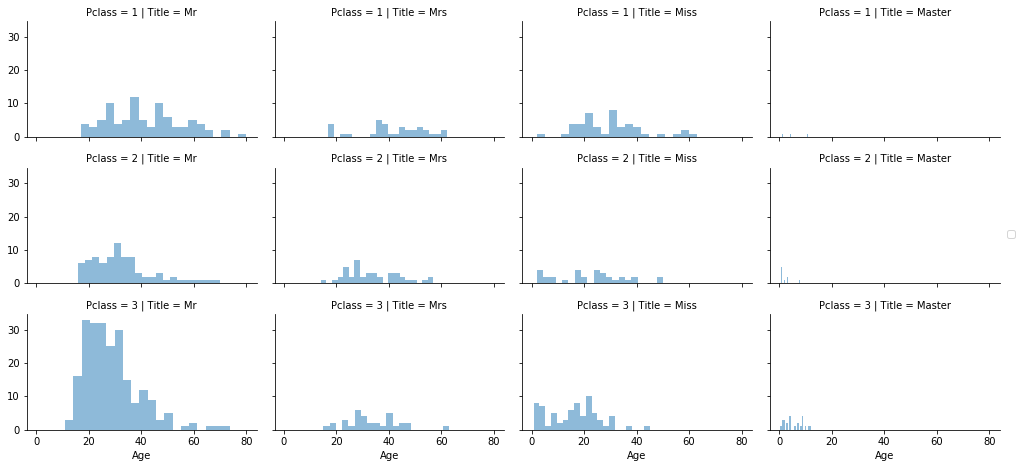

In [673]:
subdf = df[(df['Title']=='Mr') |
           (df['Title']=='Master') |
           (df['Title']=='Mrs') |
           (df['Title']=='Miss')]
grid = sns.FacetGrid(subdf, row='Pclass', col='Title', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

The distributions show that there is some relationship between *Age* and *Pclass*, in particular passengers in 3rd class tend to be yonger than others. We will use this to subset the passengers by *Title* and *Pclass* to impute the missing *Age*s.

Can we use any other features to impute *Age*? Let's check out how *Fare* and *Age* behave.

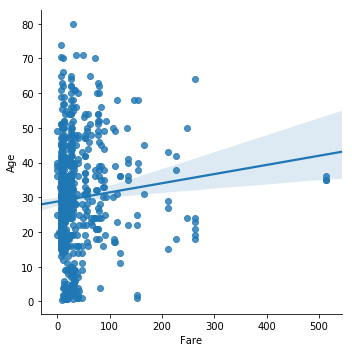

In [674]:
sns.lmplot(x = 'Fare',
           y = 'Age',
           data = df)

By itself this plot would answer no, but what if we remove the outliers with *Fare* > 500 ?

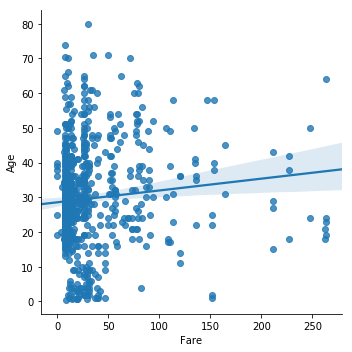

In [675]:
sns.lmplot(x = 'Fare',
           y = 'Age',
           data = df[df['Fare'] < 500])

While the answer is still NO, it is interesting how it appears that there were two well defined cheap fares. Let us briefly check that.

In [676]:
df['Fare'].value_counts().head(6)

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
10.5000    24
Name: Fare, dtype: int64

We aren't going to try any other features to impute *Age*. We will therefore fill this value with the mean age of the group the passenger belongs to, where the groups will be defined by *Title* and *Pclass*.  
When a particular combination of *Title* and *Pclass* has no data it will be filled woth the mean of the available data for the *Title* in question.

In [677]:
age_df = pd.DataFrame(index=df['Title'].unique(),columns=df['Pclass'].unique())

In [678]:
for tit in df['Title'].unique():
    for cls in [1,2,3]:
        if pd.isnull(age_df.loc[tit][cls]):
            age_df.loc[tit][cls] = df[(df['Title']==tit) & (df['Pclass']==cls)]['Age'].mean()
            if pd.isnull(age_df.loc[tit][cls]):
                age_df.loc[tit][cls] = df[df['Title']==tit]['Age'].mean()
print(age_df)

                3        1        2
Mr        28.7249  41.5805  32.7683
Mrs       33.5152  40.8824  33.6829
Miss      16.1232       30  22.3906
Master    5.35083  5.30667  2.25889
Don            40       40       40
Rev       43.1667  43.1667  43.1667
Dr             42    43.75     38.5
Mme            24       24       24
Ms             28       28       28
Major        48.5     48.5     48.5
Lady           48       48       48
Sir            49       49       49
Mlle           24       24       24
Col            58       58       58
Capt           70       70       70
Countess       33       33       33
Jonkheer       38       38       38


We can now use this DataFrame to fill in all the missing *Age* values.

In [679]:
for tit in df['Title'].unique():
    for cls in [1,2,3]:
        df.loc[ (df['Age'].isna() == True) &
                (df['Title'] == tit) &
                (df['Pclass'] == cls), 'Age'] = age_df.loc[tit,cls]


In [680]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
male        891 non-null uint8
Q           891 non-null uint8
S           891 non-null uint8
Title       891 non-null object
dtypes: float64(2), int64(4), object(1), uint8(3)
memory usage: 51.4+ KB


We have no more missing values. Let's transform the *Title* column into dummy variables.

In [681]:
# Create dummy variables for categorical features with pandas get_dummies
title = pd.get_dummies(df['Title'], drop_first=True)
df = pd.concat([df,title], axis=1, sort=False)
df.drop(['Title'], axis=1, inplace=True)

Let us also transform the *Pclass* into dummy variables since as ordinal integers they are stating that:  
"3rd class is 3 times as much as 1st class" which doesn't make any sense.

In [682]:
# Create dummy variables for categorical features with pandas get_dummies
pclass = pd.get_dummies(df['Pclass'], drop_first=True)
# keep a copy for later ;)
df_bak = df.copy()
df = pd.concat([df,pclass], axis=1, sort=False)
df.drop(['Pclass'], axis=1, inplace=True)

In [683]:
df.head()

,Survived,Age,SibSp,Parch,Fare,male,Q,S,Col,Countess,...,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,2,3
0,0,22.0,1,0,7.2500,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,1,35.0,1,0,53.1000,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,35.0,0,0,8.0500,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


The data is now ready to be split and for a logistic regression model to be fit!

In [684]:
from sklearn.model_selection import train_test_split

In [685]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [686]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [687]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [688]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [689]:
y_pred = lr.predict(X_test)

In [690]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.83      0.88      0.85       109
          1       0.79      0.71      0.75        70

avg / total       0.81      0.82      0.81       179



I am curious as to how the F1-score varies when varying the train-test split.

In [691]:
from sklearn.metrics import f1_score
vary_size = pd.DataFrame(index=np.linspace(0.1,0.9,50), columns=['test_size','F1'])
for i in np.linspace(0.1,0.9,50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    vary_size.loc[i,'test_size'] = i
    vary_size.loc[i,'F1'] = f1

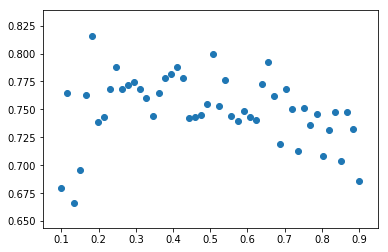

In [692]:
plt.scatter(x=vary_size['test_size'], y=vary_size['F1'])

In [693]:
from sklearn.metrics import f1_score
vary_size = pd.DataFrame(data=0,index=np.linspace(0.1,0.9,50), columns=['test_size','F1_train','F1_test'])
for j in range(1,100):
    for i in np.linspace(0.1,0.9,50):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i)
        lr.fit(X_train, y_train)
        y_pred_train = lr.predict(X_train)
        y_pred_test = lr.predict(X_test)
        f1_train = f1_score(y_train, y_pred_train)
        f1_test = f1_score(y_test, y_pred_test)
        vary_size.loc[i,'test_size'] = i
        vary_size.loc[i,'F1_train'] = (vary_size.loc[i,'F1_train']*(j - 1) + f1_train) / j
        vary_size.loc[i,'F1_test'] = (vary_size.loc[i,'F1_test']*(j - 1) + f1_test) / j
        

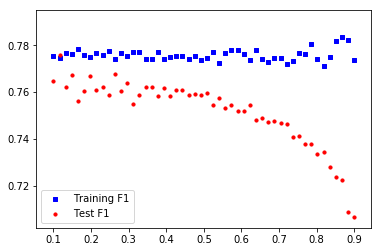

In [694]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(vary_size['test_size'],vary_size['F1_train'], s=10, c='b', marker="s", label='Training F1')
ax1.scatter(vary_size['test_size'],vary_size['F1_test'], s=10, c='r', marker="o", label='Test F1')
plt.legend(loc='lower left');
plt.show()

We can see that by increasing the size of the training set (and decreasing the size of the test set) we are improving but plateuing pretty quickly, suggesting that we don't risk overfitting.

Since we have 891 data points available we can use a large (90%) training set and still have 89 points in the test set. Let's fit the model and make a final assessment.

In [695]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.82      0.94      0.88        53
          1       0.90      0.70      0.79        37

avg / total       0.85      0.84      0.84        90



The model performs very well which is rather sad for the passengers of the Titanic.
Since we can predict their fate with such confidence it is clear that some passengers had a clear survival advantage over others. 

In particular we know that *Sex*, *Age* and *Pclass* affected the chance of survival significantly. A few plots to illustrate that:

Text(0.5,1,'Sex vs Pclass Survival Comparison')

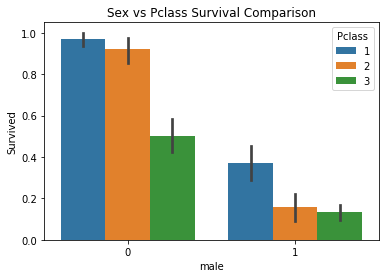

In [700]:
sns.barplot(x = 'male', y = 'Survived', hue = 'Pclass', data=df_bak)
plt.title('Sex vs Pclass Survival Comparison')